# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Network to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
#print current env PATH variable value
!printenv PATH

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [4]:
#Update PATH environment variable
# Append /root/.local/bin to the existing path environment variable to get rid of these installation warnings - f2py, f2py3 and f2py3.10 are installed in '/root/.local/bin' which is not on PATH.
%env PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/root/.local/bin

env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/root/.local/bin


In [5]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [97]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
import time
import re

from tensorflow.keras import backend

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam  #Optmizer

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score, classification_report

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [5]:
print(tf.__version__)

2.15.0


## Loading the dataset

In [350]:
# Uncomment and run the below code if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [351]:
# Load the image file of the dataset
images = np.load('/content/drive/My Drive/PlantSeedlingClassification/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/My Drive/PlantSeedlingClassification/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [352]:
print('Shape of the images array: ', images.shape)
print('Shape of the labels array: ', labels.shape)

Shape of the images array:  (4750, 128, 128, 3)
Shape of the labels array:  (4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

### Plotting Images using opencv and matplotlib

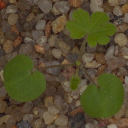

In [9]:
cv2_imshow(images[8])

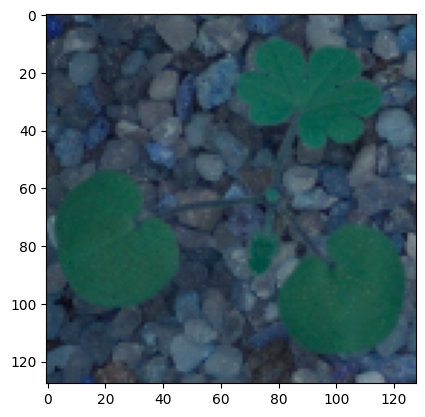

In [10]:
plt.imshow(images[8])

- We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- We will convert these BGR images to RGB images during Data Pre-Processing so we could interpret them easily.

### Plotting randomly images of each category

In [11]:
#Count of uniques plant species/categories
labels.nunique()

Label    12
dtype: int64

- We observe that there are 12 different categories of Plant species in the data set

Plot unique categories images

In [12]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  displayed_list = []

  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          if not displayed_list: #First entry :Displayed list is empty
              random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
              ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
              displayed_list.append(keys[random_index])
              ax.imshow(images[random_index, :])                                      # Plotting the image
              ax.set_title(keys[random_index])
          else :# If species is already displayed, find a new one
            while (keys[random_index] in displayed_list and len(displayed_list) < len(keys)):
                random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
            if (keys[random_index] not in displayed_list):
                displayed_list.append(keys[random_index])
                ax.imshow(images[random_index, :])                                      # Plotting the image
                ax.set_title(keys[random_index])
  plt.show()

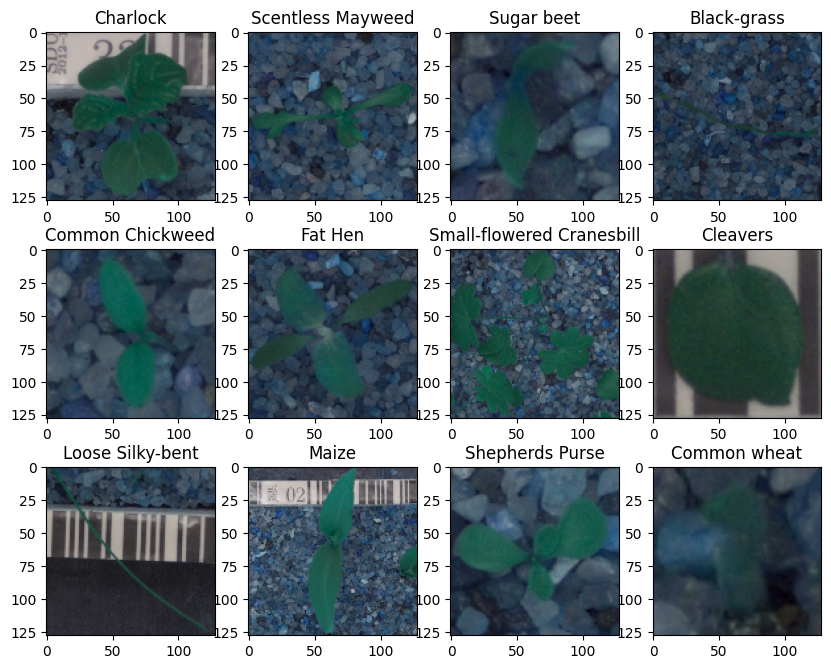

In [13]:
plot_images(images,labels)

- Each plant categories shows difference in leaf shape,leaf arrangement,color,texture,growth habit like upright,grass like,erect bracnching stem,climbers.

Based on the research of these categories here are key features of each plant categories.
1.  **Leaf Shape and Arrangement:**

* Black-grass: Long, narrow leaves with parallel veins, arranged alternately on the stem.
* Charlock: Broad, oval-shaped leaves with toothed margins, arranged alternately.
* Cleavers: Narrow, lance-shaped leaves with a whorled arrangement (multiple leaves arising from the same point on the stem).
* Common Chickweed: Oval-shaped leaves with pointed tips, arranged oppositely on the stem.
* Common Wheat: Long, narrow leaves similar to Black-grass, but often with a slightly bluish-green color.
* Fat Hen: Diamond-shaped or triangular leaves with toothed margins, arranged alternately.
* Loose Silky-bent: Fine, grass-like leaves with a delicate appearance.
* Maize: Long, broad leaves with parallel veins, arranged alternately. They often have a distinct midrib.
* Scentless Mayweed: Finely divided, feathery leaves, giving it a fern-like appearance.
* Shepherds Purse: Basal rosette of deeply lobed leaves, with smaller, arrow-shaped leaves along the stem.
* Small-flowered Cranesbill: Rounded or kidney-shaped leaves with palmate lobes (like fingers on a hand).
* Sugar beet: Large, oval-shaped leaves with prominent veins, arranged alternately.
2. **Leaf Color and Texture:**

* Black-grass: Dark green to slightly purplish.
* Charlock: Bright green with a slightly hairy texture.
* Cleavers: Light green with a slightly sticky texture.
* Common Chickweed: Light green and smooth.
Common Wheat: Bluish-green.
* Fat Hen: Dull green with a slightly mealy texture.
* Loose Silky-bent: Light green and very fine.
* Maize: Bright green with a prominent midrib.
* Scentless Mayweed: Dark green and finely divided.
* Shepherds Purse: Dark green.
* Small-flowered Cranesbill: Light to medium green, often with reddish stems.
* Sugar beet: Dark green and glossy.

3. **Growth Habit:**

* Black-grass: Upright, grass-like growth.
* Charlock: Erect with branching stems.
* Cleavers: Sprawling or climbing.
* Common Chickweed: Low-growing and mat-forming.
* Common Wheat: Upright, similar to Black-grass.
* Fat Hen: Erect with a bushy appearance.
* Loose Silky-bent: Fine, tufted growth.
* Maize: Tall and upright with a single main stem.
* Scentless Mayweed: Erect and branching.
* Shepherds Purse: Basal rosette with a flowering stem.
* Small-flowered Cranesbill: Low-growing and spreading.
* Sugar beet: Rosette of leaves with a large taproot.

**Challenges:**

Some seedlings may have similar features, especially at early growth stages, making classification challenging.
Variations in lighting, image quality, and seedling age can further complicate the task.


### Checking for data imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

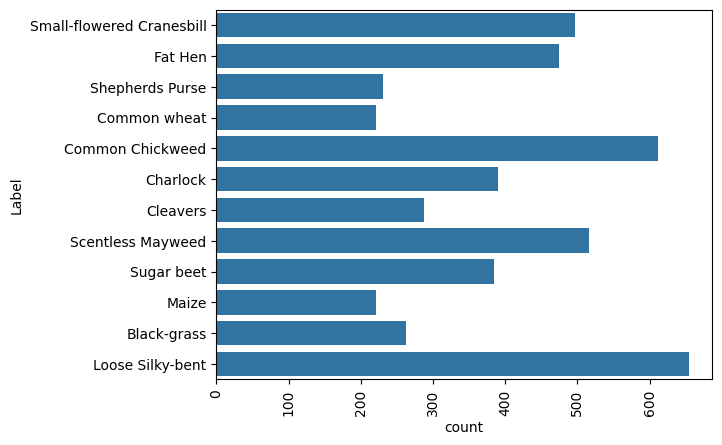

In [14]:
#Plot the countplot of each category
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

- As you can see from the above plot, the dataset is quite imbalanced.

In [15]:
#count each plant species
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

**Observations from EDA**
- dataset is quite imbalanced.
- Range of each categories varies from 221 to 654.
- Loose Silky-bent is the highest category and has around 654 images
- Second highest category is Common Chickweed around 611 images
- Maize and Common wheat have around 221 images lowest count in the dataset


## Data Pre-Processing

### Convert the BGR images to RGB images.

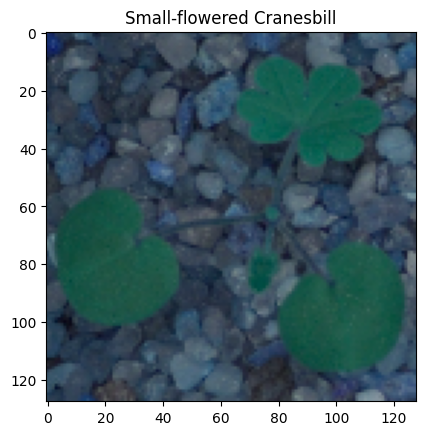

In [353]:
#Check before RGB conversion in matplotlib
plt.imshow(images[8])
plt.title(labels.iloc[8,0])
plt.show()

In [354]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

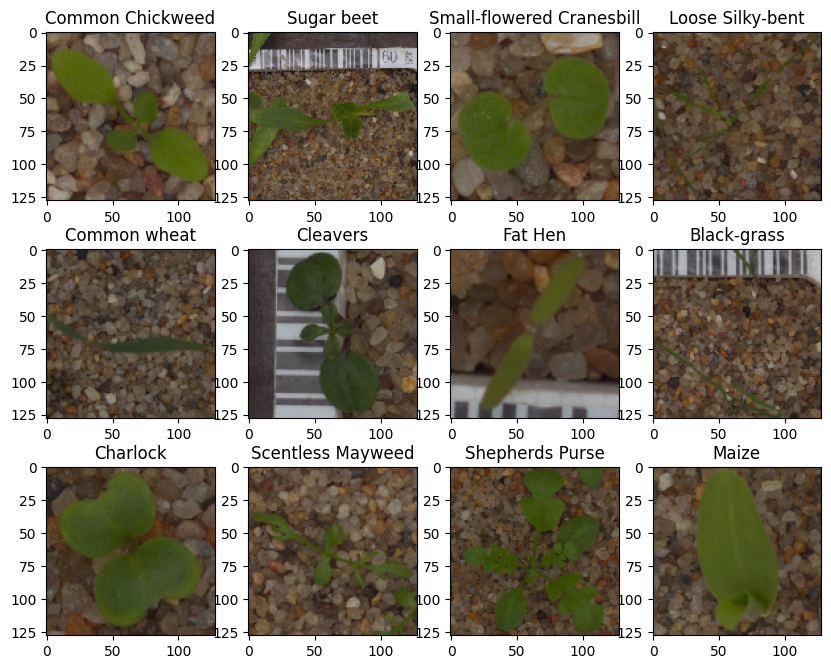

In [355]:
#Check after RGB conversion in matplotlib each category
plot_images(images,labels)

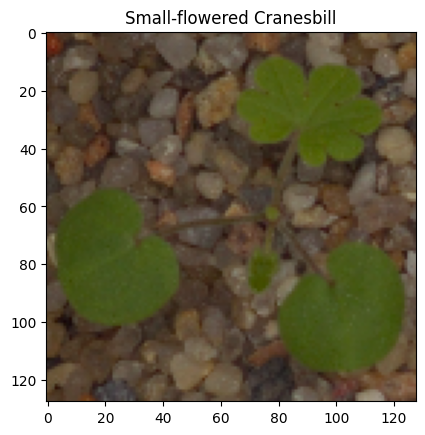

In [356]:
#Display one image after RGB conversion in matplotlib
plt.imshow(images[8])
plt.title(labels.iloc[8,0])
plt.show()

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [357]:
#reduce the size of the image
resized_images = []  # Create a new list to store resized images
for i in range(len(images)):
  resized_image = cv2.resize(images[i], (64,64), interpolation = cv2.INTER_AREA)
  resized_images.append(resized_image)

images = np.array(resized_images)

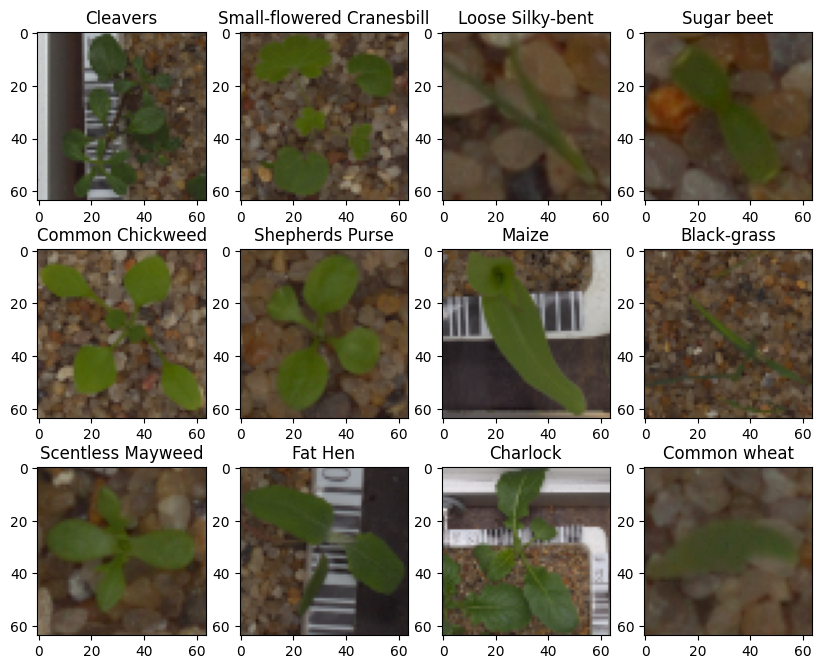

In [358]:
#Display images after resized images
plot_images(images,labels)

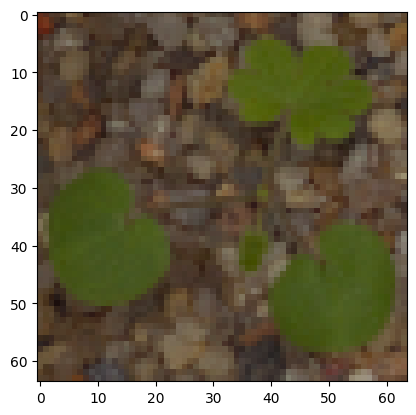

In [359]:
#Display one image with dimension info
plt.imshow(images[8])

-We observe reduced image Size 64 x 64 as compared to original 124 X 124

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

### Split the dataset
- We will  use 20% of our data for testing, 20% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.


In [360]:
images.shape

(4750, 64, 64, 3)

In [361]:
X_temp ,X_test, y_temp,y_test = train_test_split(images, labels, test_size=0.2, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42,stratify=y_temp)

In [362]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (3040, 64, 64, 3)
Shape of X_val: (760, 64, 64, 3)
Shape of X_test: (950, 64, 64, 3)


In [363]:
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of y_test:', y_test.shape)

Shape of y_train: (3040, 1)
Shape of y_val: (760, 1)
Shape of y_test: (950, 1)


In [364]:
# Check count of each class training dataset


unique_categories, category_counts = np.unique(y_train, return_counts=True)

# Print the category names and their counts
for category, count in zip(unique_categories, category_counts):
    print(f"{category}: {count}")

Black-grass: 168
Charlock: 250
Cleavers: 183
Common Chickweed: 391
Common wheat: 142
Fat Hen: 304
Loose Silky-bent: 418
Maize: 142
Scentless Mayweed: 330
Shepherds Purse: 148
Small-flowered Cranesbill: 318
Sugar beet: 246


### Encode the target labels

In [365]:
# Convert labels from names to one hot vectors.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
# Applying fit_transform on train target variable
y_train_encoded = enc.fit_transform(y_train)
# Applying only transform on val and test target variable
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization
Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [366]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building
Let's create a CNN model sequentially, where we will be adding the layers one after another.

### Helper Functions for Model Building

In [31]:
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.


In [32]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1

    The choice of the threshold depends on the specific business problem and the desired balance between different types of errors:

    Higher Threshold (e.g., 0.7): This leads to higher precision (fewer false positives) but lower recall (more false negatives).
    It's suitable when the cost of false positives is high, like in spam detection.
    Lower Threshold (e.g., 0.3): This leads to higher recall (fewer false negatives) but lower precision (more false positives).
    It's suitable when the cost of false negatives is high, like in disease diagnosis.

    Using threshold of 0.5 in this case

    """


    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) > threshold

    # pred_temp = model.predict(predictors) > threshold
    # # rounding off the above values to get classes
    # pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average='weighted',zero_division=1)  # to compute Recall
    precision = precision_score(target, pred,average='weighted',zero_division=1)  # to compute Precision
    f1 = f1_score(target, pred,average='weighted',zero_division=1)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},
        index=[0],
    )

    return df_perf

In [33]:
# Plots the heat map if tensorflow confusion matrix
def plot_confusion_matrix(y_test_classes,y_pred_classes):
    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(y_test_classes,y_pred_classes)
    f, ax = plt.subplots(figsize=(10, 8))
    plt.title('Confusion Matrix')

    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


### Model Evaluation Criterion

F1-Score for Plant Seedling Classification.
We will look at all the metrics to review the model performance.
**Accuracy ** is used to compile the model and also used to check the overall performance along with F1-score.

Potential Class Imbalance: Plant seedling datasets has class imbalance, where some species are more represented than others. Accuracy can be misleading in such cases.

Importance of Correct Identification: In agriculture, correctly identifying all instances of a particular species (especially weeds or invasive plants) might be crucial for timely intervention. This aligns with the focus of recall and the F1-score.

Comprehensive Evaluation: The F1-score provides a more balanced view of the model's performance, considering both precision and recall. It helps ensure the model is not only accurate overall but also effective in identifying all instances of important classes



### Model1 : CNN Model

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow to be able to reproduce the same results every time we run the code.

In [238]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [239]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [240]:
# Intializing a sequential model
model1 = Sequential()

#Define the convolutional layer for Feature Extraction

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images

model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))


# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())
# Adding a fully connected dense layer
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(12, activation='softmax'))



In [241]:
# Adam as Optimizer
opt=Adam()
# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 16)                1

#### Fitting the model on training data

In [242]:
start = time.time()
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)
end=time.time()

Epoch 1/30
95/95 - 6s - loss: 2.4337 - accuracy: 0.1395 - val_loss: 2.3158 - val_accuracy: 0.2132 - 6s/epoch - 63ms/step
Epoch 2/30
95/95 - 5s - loss: 2.2039 - accuracy: 0.2421 - val_loss: 1.9942 - val_accuracy: 0.3421 - 5s/epoch - 53ms/step
Epoch 3/30
95/95 - 5s - loss: 2.0104 - accuracy: 0.2964 - val_loss: 1.8476 - val_accuracy: 0.3566 - 5s/epoch - 57ms/step
Epoch 4/30
95/95 - 5s - loss: 1.9094 - accuracy: 0.2947 - val_loss: 1.7443 - val_accuracy: 0.4053 - 5s/epoch - 53ms/step
Epoch 5/30
95/95 - 5s - loss: 1.8613 - accuracy: 0.3401 - val_loss: 1.6699 - val_accuracy: 0.3987 - 5s/epoch - 54ms/step
Epoch 6/30
95/95 - 5s - loss: 1.7871 - accuracy: 0.3605 - val_loss: 1.6050 - val_accuracy: 0.4118 - 5s/epoch - 54ms/step
Epoch 7/30
95/95 - 5s - loss: 1.7667 - accuracy: 0.3592 - val_loss: 1.6642 - val_accuracy: 0.4526 - 5s/epoch - 51ms/step
Epoch 8/30
95/95 - 5s - loss: 1.7447 - accuracy: 0.3503 - val_loss: 1.5809 - val_accuracy: 0.4461 - 5s/epoch - 55ms/step
Epoch 9/30
95/95 - 5s - loss: 1.

In [243]:
model1_time = end-start
print("Time taken in minutes ",model1_time/60)

Time taken in minutes  2.528558937708537


#### Model Evaluation

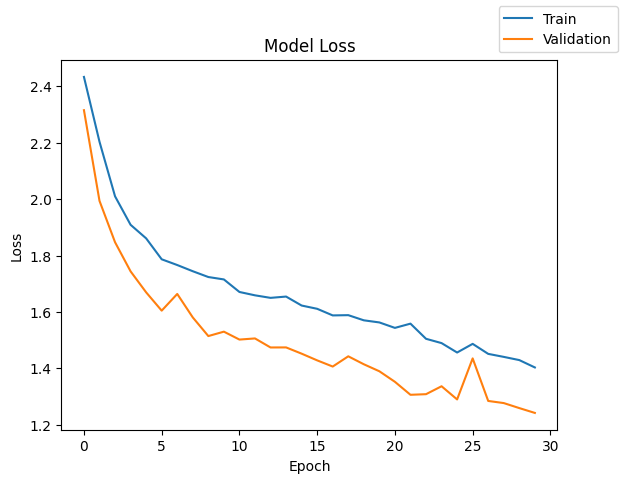

In [244]:
#Plot of Model Loss
plot(history_1,'loss')

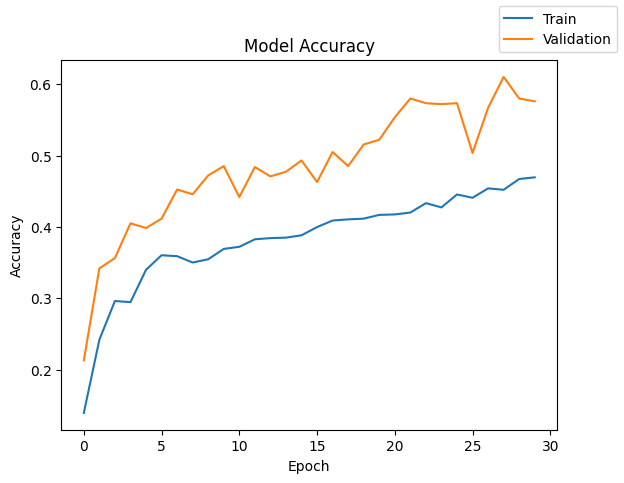

In [245]:
#plot of model accuracy
plot(history_1,'accuracy')

In [246]:
#Evaluate the model on test data
#model.evaluate() is used to evaluate the model's performance on the test dataset (X_test_normalized, y_test_encoded). This is the correct approach to get a final, unbiased assessment of the trained model
accuracy1 = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 1.2004 - accuracy: 0.6084 - 332ms/epoch - 11ms/step


In [247]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)

30/30 [==============================] - 0s 12ms/step


#### Model Performance and Confusion Matrix

In [248]:
# Model Performance on training data
model1_train_perf = model_performance_classification(model1,X_train_normalized,y_train_encoded)
print(model1_train_perf)

95/95 [==============================] - 1s 13ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.437829  0.437829   0.889654    0.4764


In [249]:
# Model Performance on validation data
model1_val_perf = model_performance_classification(model1,X_val_normalized,y_val_encoded)
print(model1_val_perf)

24/24 [==============================] - 0s 14ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.351316  0.351316   0.662824   0.39743


In [250]:
# Model Performance on testing data
model1_test_perf = model_performance_classification(model1,X_test_normalized,y_test_encoded)
print(model1_test_perf)

30/30 [==============================] - 0s 14ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.372632  0.372632   0.739194  0.401501


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [251]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report1 = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report1)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        53
           1       0.89      0.74      0.81        78
           2       0.74      0.34      0.47        58
           3       0.62      0.85      0.71       122
           4       0.00      0.00      0.00        44
           5       0.50      0.64      0.56        95
           6       0.54      0.95      0.69       131
           7       1.00      0.00      0.00        44
           8       0.58      0.70      0.63       103
           9       0.36      0.09      0.14        46
          10       0.78      0.84      0.81        99
          11       0.57      0.66      0.61        77

    accuracy                           0.61       950
   macro avg       0.63      0.49      0.45       950
weighted avg       0.63      0.61      0.55       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

**Test Data Performance**
- **We observe accuracy of 61% **
- **Macro Average F1 score of 45%**
- **Weighted average F1 score of 55%**

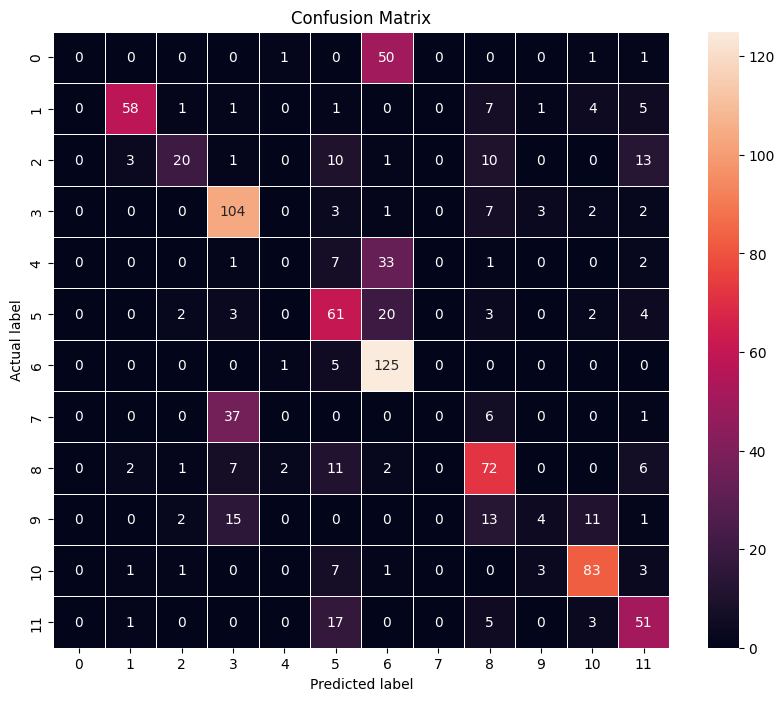

In [252]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- We observe that majority of the classes are not predicted correctly.Accuracy of 61% on test data.
- In comparison to the rest, we can see that classes 1,  3 ,5,6 , 8,10 and 11 are classified better.
- We can also observe that classes 0,7 and 4 are mostly misclassified.

## Model Performance Improvement

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation to check if we can improve the model's performance.

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### Model 2: Data Augmentation Model - Rotation Technique
Images are rotated

Remember, **data augmentation should not be used in the validation/test data set**.

In [49]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [50]:
# Data generator with rotation set
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [51]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(12, activation='softmax'))



In [52]:
#Use Adam Optimizer
opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 16)                1

#### Fitting the model on training data

In [53]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

augmented_data = train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False)


In [54]:
start = time.time()
history_2 = model2.fit(augmented_data,
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=2)
end = time.time()

Epoch 1/30
47/47 - 7s - loss: 2.4433 - accuracy: 0.1376 - val_loss: 2.4023 - val_accuracy: 0.1132 - 7s/epoch - 146ms/step
Epoch 2/30
47/47 - 6s - loss: 2.3785 - accuracy: 0.1821 - val_loss: 2.2719 - val_accuracy: 0.2526 - 6s/epoch - 130ms/step
Epoch 3/30
47/47 - 6s - loss: 2.2037 - accuracy: 0.2248 - val_loss: 2.0605 - val_accuracy: 0.2697 - 6s/epoch - 123ms/step
Epoch 4/30
47/47 - 6s - loss: 2.0335 - accuracy: 0.2718 - val_loss: 1.8806 - val_accuracy: 0.4487 - 6s/epoch - 126ms/step
Epoch 5/30
47/47 - 6s - loss: 1.9312 - accuracy: 0.3189 - val_loss: 1.7497 - val_accuracy: 0.4684 - 6s/epoch - 126ms/step
Epoch 6/30
47/47 - 6s - loss: 1.8355 - accuracy: 0.3666 - val_loss: 1.6087 - val_accuracy: 0.4908 - 6s/epoch - 125ms/step
Epoch 7/30
47/47 - 6s - loss: 1.7458 - accuracy: 0.3770 - val_loss: 1.5568 - val_accuracy: 0.5224 - 6s/epoch - 123ms/step
Epoch 8/30
47/47 - 6s - loss: 1.6789 - accuracy: 0.4049 - val_loss: 1.4661 - val_accuracy: 0.5197 - 6s/epoch - 130ms/step
Epoch 9/30
47/47 - 6s - 

In [55]:
model2_time = end-start
print("Time taken in minutes ",model2_time/60)

Time taken in minutes  3.0522127310434977


#### Model Evaluation

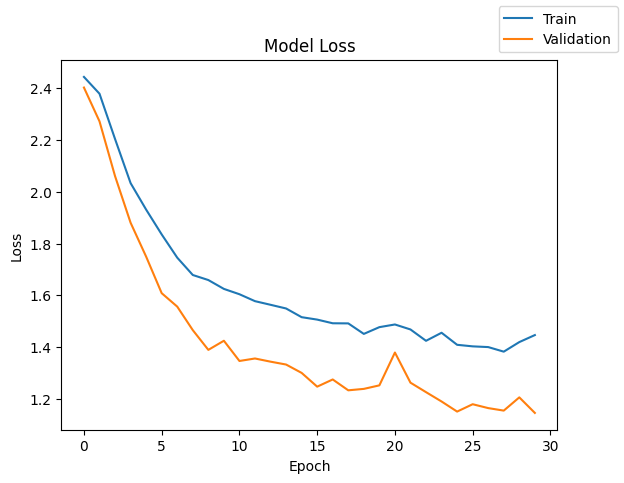

In [56]:
#Plot of Model Loss
plot(history_2,'loss')

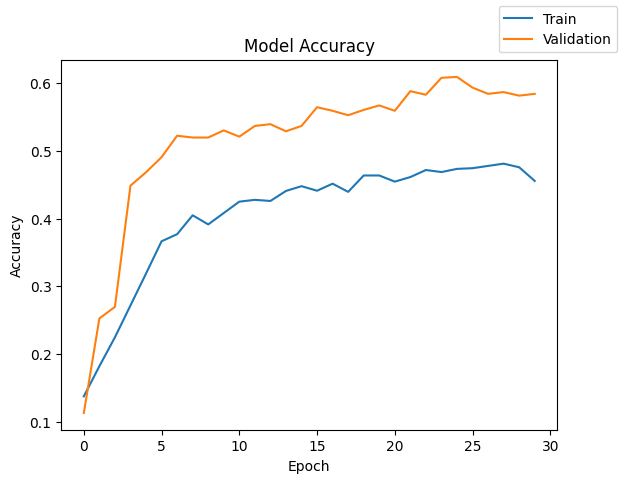

In [57]:
#plot of model accuracy
plot(history_2,'accuracy')

In [58]:
#Evaluate the model on test data
accuracy2 = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 1.1469 - accuracy: 0.5863 - 391ms/epoch - 13ms/step


In [59]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model2.predict(X_test_normalized)

30/30 [==============================] - 0s 12ms/step


#### Model Performance and Confusion Matrix

In [60]:
# Model Performance on training data
model2_train_perf = model_performance_classification(model2,X_train_normalized,y_train_encoded)
print(model1_train_perf)

95/95 [==============================] - 1s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.437829  0.437829   0.889654    0.4764


In [61]:
# Model Performance on validation data
model2_val_perf = model_performance_classification(model2,X_val_normalized,y_val_encoded)
print(model1_val_perf)

24/24 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.351316  0.351316   0.662824   0.39743


In [62]:
# Model Performance on testing data
model2_test_perf = model_performance_classification(model2,X_test_normalized,y_test_encoded)
print(model2_test_perf)

30/30 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.397895  0.397895   0.809316  0.422596


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [63]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report2 = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report2)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        53
           1       0.82      0.78      0.80        78
           2       0.74      0.69      0.71        58
           3       0.60      0.93      0.73       122
           4       1.00      0.00      0.00        44
           5       0.40      0.55      0.46        95
           6       0.52      0.98      0.68       131
           7       1.00      0.00      0.00        44
           8       0.59      0.69      0.63       103
           9       0.31      0.11      0.16        46
          10       0.76      0.74      0.75        99
          11       0.57      0.17      0.26        77

    accuracy                           0.59       950
   macro avg       0.69      0.47      0.43       950
weighted avg       0.65      0.59      0.52       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

- **We observe accuracy of 59%**
- **Macro Average F1 score of 43%**
- **Weighted average F1 score of 52%**

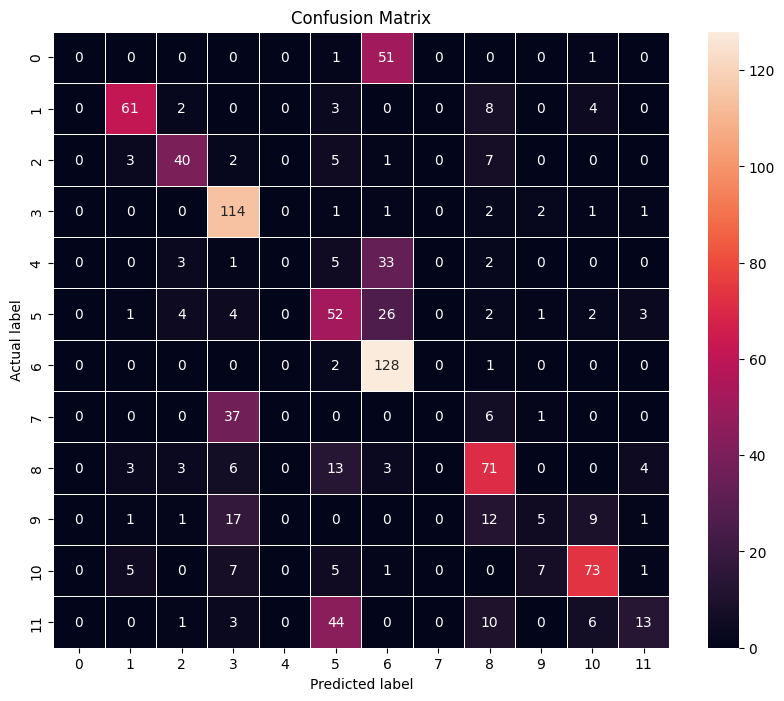

In [64]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> <b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- We observe that majority of the classes are not predicted correctly. Model is performing with accuracy of 59%.
- In comparison to the rest, we can see that classes 3,  6 , 10 are classified better.
- 0 ,4,7 are mostly wrongly predicted.
- We can also observe that classes 9 and 11 are poorly misclassified.

### Model 3: Data Augmentation Model with other augmentation techniques

In [215]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [216]:
# Augmentation techniques used.
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode='nearest'
                              )

In [217]:
# Intializing a sequential model
model3 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model3.add(Flatten())
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(12, activation='softmax'))



In [218]:
#Use Adam Optimizer
opt=Adam()
# Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 16)                1

#### Fitting the model on training data

In [219]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

augmented_data = train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False)


In [220]:
start = time.time()
history_3 = model3.fit(augmented_data,
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=2)
end = time.time()

Epoch 1/30
47/47 - 8s - loss: 2.3958 - accuracy: 0.1657 - val_loss: 2.2585 - val_accuracy: 0.2211 - 8s/epoch - 161ms/step
Epoch 2/30
47/47 - 7s - loss: 2.2400 - accuracy: 0.2483 - val_loss: 2.1347 - val_accuracy: 0.3000 - 7s/epoch - 139ms/step
Epoch 3/30
47/47 - 6s - loss: 2.1532 - accuracy: 0.2735 - val_loss: 1.9928 - val_accuracy: 0.3461 - 6s/epoch - 136ms/step
Epoch 4/30
47/47 - 6s - loss: 2.0896 - accuracy: 0.2981 - val_loss: 1.9293 - val_accuracy: 0.3737 - 6s/epoch - 135ms/step
Epoch 5/30
47/47 - 6s - loss: 2.0361 - accuracy: 0.3112 - val_loss: 1.8478 - val_accuracy: 0.3868 - 6s/epoch - 136ms/step
Epoch 6/30
47/47 - 6s - loss: 1.9676 - accuracy: 0.3118 - val_loss: 1.7258 - val_accuracy: 0.4026 - 6s/epoch - 136ms/step
Epoch 7/30
47/47 - 6s - loss: 1.9219 - accuracy: 0.3276 - val_loss: 1.7134 - val_accuracy: 0.4316 - 6s/epoch - 135ms/step
Epoch 8/30
47/47 - 6s - loss: 1.9023 - accuracy: 0.3303 - val_loss: 1.7075 - val_accuracy: 0.4539 - 6s/epoch - 131ms/step
Epoch 9/30
47/47 - 6s - 

In [221]:
model3_time = end-start
print("Time taken in minutes ",model3_time/60)

Time taken in minutes  3.156686536471049


#### Model Evaluation

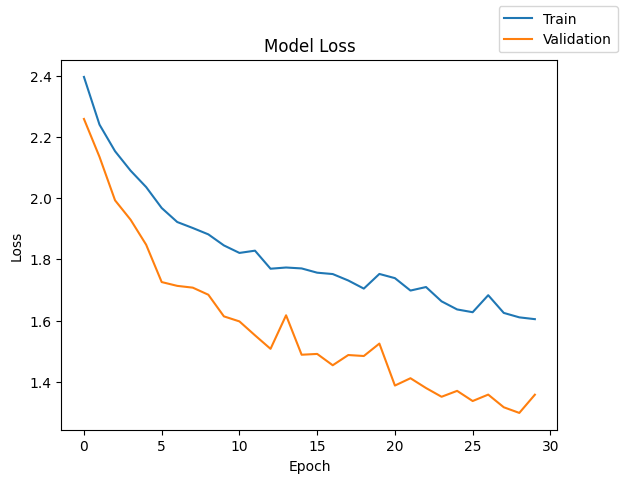

In [222]:
#Plot of Model Loss
plot(history_3,'loss')

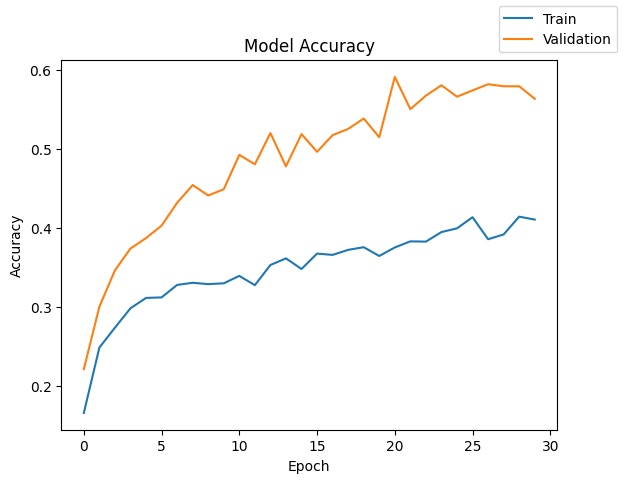

In [223]:
#plot of model accuracy
plot(history_3,'accuracy')

In [224]:
#Evaluate the model on test data
accuracy3 = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 1.3592 - accuracy: 0.5726 - 369ms/epoch - 12ms/step


In [225]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model3.predict(X_test_normalized)

30/30 [==============================] - 0s 13ms/step


#### Model Performance and Confusion Matrix

In [226]:
# Model Performance on training data
model3_train_perf = model_performance_classification(model3,X_train_normalized,y_train_encoded)
print(model3_train_perf)

95/95 [==============================] - 1s 12ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.217434  0.217434   0.833575  0.266767


In [227]:
# Model Performance on validation data
model3_val_perf = model_performance_classification(model3,X_val_normalized,y_val_encoded)
print(model3_val_perf)

24/24 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.206579  0.206579   0.949299  0.255691


In [228]:
# Model Performance on testing data
model3_test_perf = model_performance_classification(model3,X_test_normalized,y_test_encoded)
print(model3_test_perf)

30/30 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.223158  0.223158   0.891805  0.266118


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [229]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report3 = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report3)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        53
           1       0.45      0.96      0.62        78
           2       0.57      0.45      0.50        58
           3       0.61      0.93      0.74       122
           4       1.00      0.00      0.00        44
           5       0.63      0.36      0.46        95
           6       0.60      0.90      0.72       131
           7       1.00      0.00      0.00        44
           8       0.58      0.62      0.60       103
           9       0.33      0.02      0.04        46
          10       0.64      0.88      0.74        99
          11       0.50      0.32      0.39        77

    accuracy                           0.57       950
   macro avg       0.66      0.45      0.40       950
weighted avg       0.63      0.57      0.50       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

-  **We observe accuracy of 57%**
- **Macro Average F1 score of 40%**
- **Weighted average F1 score of 50%**

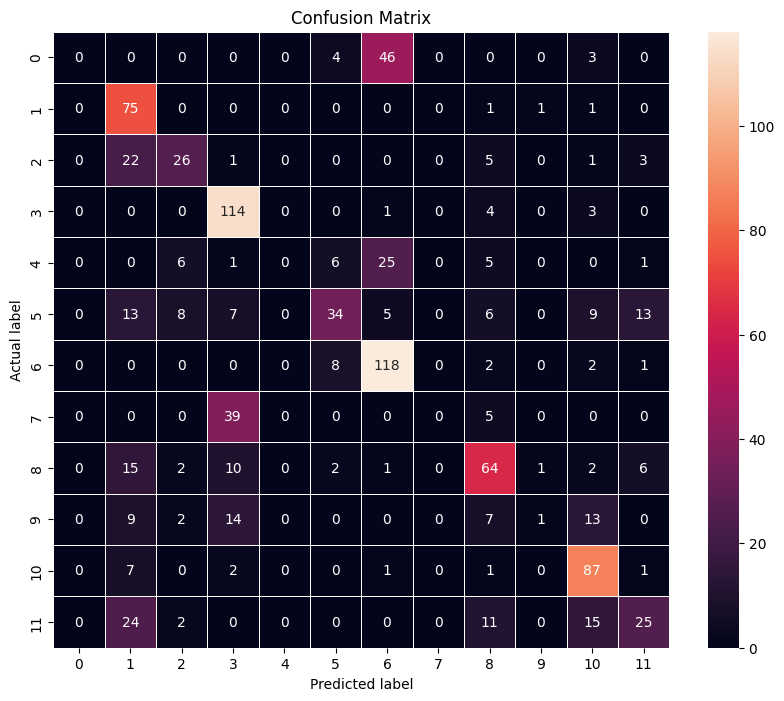

In [230]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- Model accuracy of 57%
- We observe that majority of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes  1,3 ,6 and 10 are  classified better.
- We can also observe that classes 0,4,7 are classified worst.
-

### Model 4: Data Augmentation - Model using ReduceLRonPlateau()

In [81]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [82]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [83]:
# Intializing a sequential model
model4 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model4.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model4.add(Flatten())
model4.add(Dense(16, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(12, activation='softmax'))



In [84]:
#Use Adam Optimizer
opt=Adam()
# Compile model
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 16)                1

#### Fitting the model on training data using ReduceLRonPlateau()

callbacks

In [85]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

start = time.time()
history_4 = model4.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    callbacks=[reduce_lr],
                   verbose=2)
end = time.time()

Epoch 1/30
47/47 - 7s - loss: 2.4520 - accuracy: 0.1149 - val_loss: 2.4276 - val_accuracy: 0.1382 - lr: 0.0010 - 7s/epoch - 145ms/step
Epoch 2/30
47/47 - 7s - loss: 2.4406 - accuracy: 0.1243 - val_loss: 2.4193 - val_accuracy: 0.1382 - lr: 0.0010 - 7s/epoch - 156ms/step
Epoch 3/30
47/47 - 6s - loss: 2.4315 - accuracy: 0.1203 - val_loss: 2.4055 - val_accuracy: 0.1382 - lr: 0.0010 - 6s/epoch - 137ms/step
Epoch 4/30
47/47 - 6s - loss: 2.4173 - accuracy: 0.1502 - val_loss: 2.4110 - val_accuracy: 0.1382 - lr: 0.0010 - 6s/epoch - 124ms/step
Epoch 5/30
47/47 - 6s - loss: 2.4054 - accuracy: 0.1495 - val_loss: 2.3643 - val_accuracy: 0.2000 - lr: 0.0010 - 6s/epoch - 129ms/step
Epoch 6/30
47/47 - 6s - loss: 2.3630 - accuracy: 0.1640 - val_loss: 2.3032 - val_accuracy: 0.1974 - lr: 0.0010 - 6s/epoch - 124ms/step
Epoch 7/30
47/47 - 6s - loss: 2.3134 - accuracy: 0.1996 - val_loss: 2.2062 - val_accuracy: 0.2500 - lr: 0.0010 - 6s/epoch - 129ms/step
Epoch 8/30
47/47 - 6s - loss: 2.2348 - accuracy: 0.2345

In [86]:
model4_time = end-start
print("Time taken in minutes ",model4_time/60)

Time taken in minutes  3.477506466706594


#### Model Evaluation

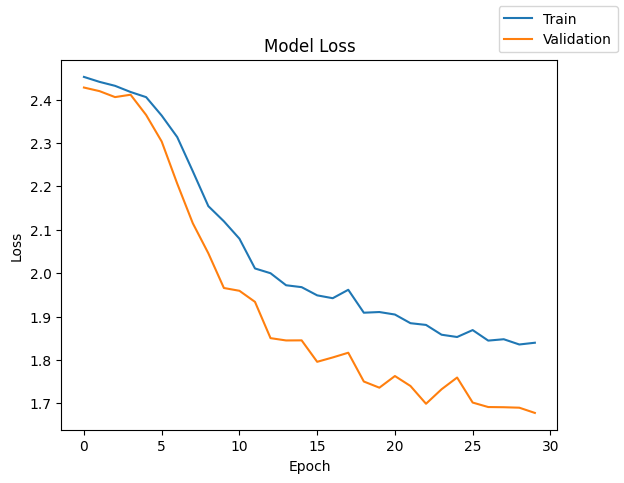

In [87]:
#Plot of Model Loss
plot(history_4,'loss')

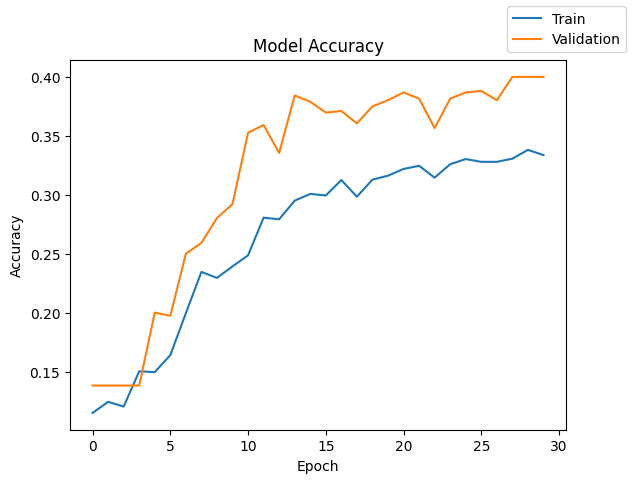

In [88]:
#plot of model accuracy
plot(history_4,'accuracy')

In [89]:
#Evaluate the model on test data
accuracy4 = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 1.6591 - accuracy: 0.4105 - 412ms/epoch - 14ms/step


In [90]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model4.predict(X_test_normalized)

30/30 [==============================] - 0s 12ms/step


#### Model Performance and Confusion Matrix

In [91]:
# Model Performance on training data
model4_train_perf = model_performance_classification(model4,X_train_normalized,y_train_encoded)
print(model4_train_perf)

95/95 [==============================] - 1s 12ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.132566  0.132566   0.915927  0.144398


In [92]:
# Model Performance on validation data
model4_val_perf = model_performance_classification(model4,X_val_normalized,y_val_encoded)
print(model4_val_perf)

24/24 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.119737  0.119737   0.925943     0.139


In [93]:
# Model Performance on testing data
model4_test_perf = model_performance_classification(model4,X_test_normalized,y_test_encoded)
print(model4_test_perf)

30/30 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.127368  0.127368    0.91757  0.139435


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [94]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report4 = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report4)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        53
           1       1.00      0.00      0.00        78
           2       1.00      0.00      0.00        58
           3       0.39      0.91      0.55       122
           4       1.00      0.00      0.00        44
           5       0.37      0.52      0.43        95
           6       0.54      0.92      0.68       131
           7       1.00      0.00      0.00        44
           8       0.32      0.17      0.23       103
           9       1.00      0.00      0.00        46
          10       0.36      0.92      0.52        99
          11       1.00      0.00      0.00        77

    accuracy                           0.41       950
   macro avg       0.75      0.29      0.20       950
weighted avg       0.65      0.41      0.29       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

- **We observe accuracy of 41%**
- **Macro Average F1 score of 20%**
- **Weighted average F1 score of 29%**

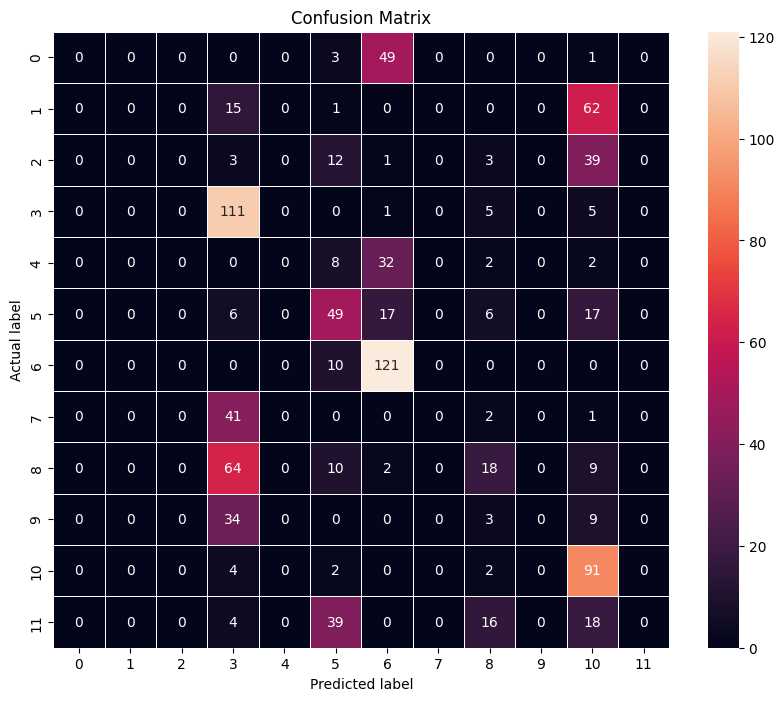

In [95]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- We observe that majority of the classes are not predicted correctly.
Model performance is not good
- In comparison to the rest, we can see that classes 0,1, 2, 4,7,9,11 are all not predicted correctly.
- We can also observe that classes 3,6 and 10 only are classified better

### Model 5: Data Augmentation Model and Batch Normalization

In [367]:
# Clearing backend

backend.clear_session()

In [368]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

When building our custom model, we have used Batch Normalization and Dropout layers as regularization techniques to prevent overfitting.

In [369]:
# Intializing a sequential model
model5 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model5.add(MaxPooling2D((2, 2)))
model5.add(BatchNormalization())

model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model5.add(Flatten())
model5.add(Dense(16, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(12, activation='softmax'))



In [370]:
#Use Adam Optimizer
opt=Adam()
# Compile model
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                        

#### Fitting the model on training data using ReduceLRonPlateau()

callbacks set

In [372]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

start = time.time()
history_5 = model5.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    callbacks=[reduce_lr],
                   verbose=2)
end = time.time()

Epoch 1/30
47/47 - 6s - loss: 2.2279 - accuracy: 0.2426 - val_loss: 2.4677 - val_accuracy: 0.2329 - lr: 0.0010 - 6s/epoch - 137ms/step
Epoch 2/30
47/47 - 6s - loss: 2.1242 - accuracy: 0.2796 - val_loss: 2.4652 - val_accuracy: 0.1382 - lr: 0.0010 - 6s/epoch - 137ms/step
Epoch 3/30
47/47 - 6s - loss: 2.0484 - accuracy: 0.3088 - val_loss: 2.4361 - val_accuracy: 0.2224 - lr: 0.0010 - 6s/epoch - 132ms/step
Epoch 4/30
47/47 - 7s - loss: 1.9673 - accuracy: 0.3337 - val_loss: 2.4472 - val_accuracy: 0.1382 - lr: 0.0010 - 7s/epoch - 141ms/step
Epoch 5/30
47/47 - 6s - loss: 1.8849 - accuracy: 0.3659 - val_loss: 2.3784 - val_accuracy: 0.2092 - lr: 0.0010 - 6s/epoch - 131ms/step
Epoch 6/30
47/47 - 7s - loss: 1.8502 - accuracy: 0.3696 - val_loss: 2.3643 - val_accuracy: 0.2908 - lr: 0.0010 - 7s/epoch - 140ms/step
Epoch 7/30
47/47 - 6s - loss: 1.7847 - accuracy: 0.4009 - val_loss: 2.2215 - val_accuracy: 0.3632 - lr: 0.0010 - 6s/epoch - 131ms/step
Epoch 8/30
47/47 - 7s - loss: 1.7806 - accuracy: 0.3959

In [374]:
model5_time = end-start
print("Time taken in minutes ",model5_time/60)

Time taken in minutes  3.2623358964920044


#### Model Evaluation

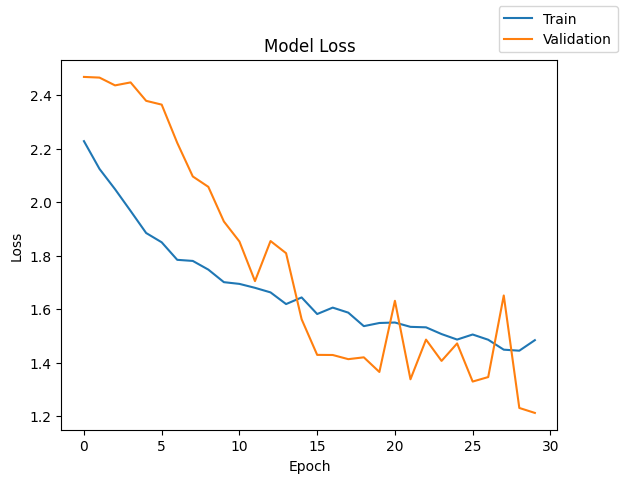

In [375]:
#Plot of Model Loss
plot(history_5,'loss')

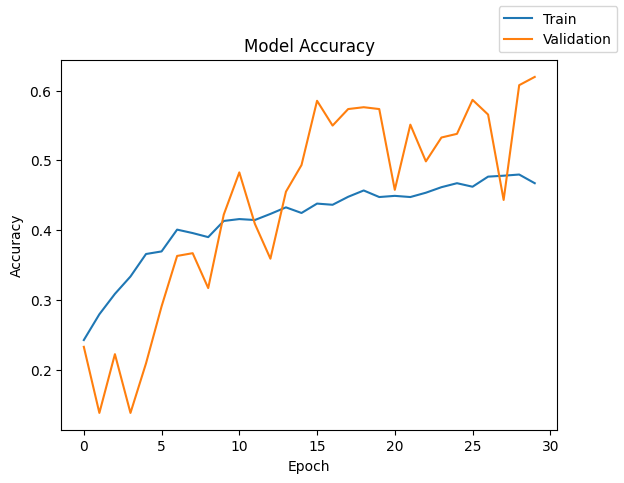

In [376]:
#plot of model accuracy
plot(history_5,'accuracy')

In [377]:
#Evaluate the model on test data
accuracy5 = model5.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 1.2551 - accuracy: 0.6137 - 388ms/epoch - 13ms/step


In [378]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model5.predict(X_test_normalized)

30/30 [==============================] - 0s 13ms/step


#### Model Performance and Confusion Matrix

In [379]:
# Model Performance on training data
model5_train_perf = model_performance_classification(model5,X_train_normalized,y_train_encoded)
print(model5_train_perf)

95/95 [==============================] - 1s 12ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.416447  0.416447   0.917016  0.437219


In [380]:
# Model Performance on validation data
model5_val_perf = model_performance_classification(model5,X_val_normalized,y_val_encoded)
print(model5_val_perf)

24/24 [==============================] - 0s 10ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.377632  0.377632   0.884441  0.396408


In [108]:
# Model Performance on testing data
model5_test_perf = model_performance_classification(model5,X_test_normalized,y_test_encoded)
print(model5_test_perf)

30/30 [==============================] - 0s 13ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.005263  0.005263        1.0   0.01002


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [381]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report5 = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report5)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        53
           1       0.55      0.92      0.69        78
           2       0.69      0.34      0.46        58
           3       0.61      0.91      0.73       122
           4       1.00      0.00      0.00        44
           5       0.85      0.73      0.78        95
           6       0.59      0.95      0.73       131
           7       1.00      0.00      0.00        44
           8       0.54      0.77      0.63       103
           9       0.00      0.00      0.00        46
          10       0.67      0.88      0.76        99
          11       0.53      0.27      0.36        77

    accuracy                           0.61       950
   macro avg       0.67      0.48      0.43       950
weighted avg       0.65      0.61      0.53       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

- **We observe accuracy of 61%**
- **Macro Average F1 score of 43%**
- **Weighted average F1 score of 53%**

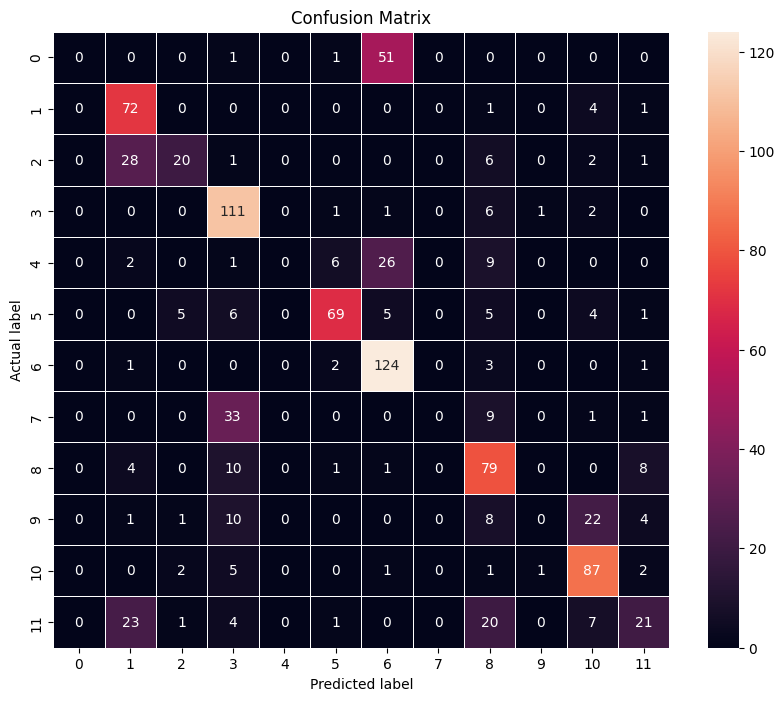

In [382]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- We observe accuracy of the model is 61% better than other data augmentation model.
- In comparison to the rest, we can see that classes 1,3,6,8 ,10 are well classified.
- 0,4,7,9 are not predictly correctly

### Model 6: Data Augmentation Model to overcome imbalance problem

Remember, **data augmentation should not be used in the validation/test data set**.

#### Prepare augmented data for minority class
Identify Minority and Majority Classes and Apply Augmentations to Minority Class

In [318]:
# Assuming 'y_train' contains the labels for your training data
from collections import Counter

class_counts = Counter(y_train['Label'])
minority_classes = [cls for cls, count in class_counts.items() if count < 300]
majority_classes = [cls for cls, count in class_counts.items() if count >= 300]
print("Minority Classes:", minority_classes)
print("Majority Classes:", majority_classes)

Minority Classes: ['Cleavers', 'Sugar beet', 'Black-grass', 'Maize', 'Charlock', 'Shepherds Purse', 'Common wheat']
Majority Classes: ['Scentless Mayweed', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Fat Hen', 'Common Chickweed']


In [319]:
# Create boolean mask to subset X_train_normalized and y_train_encoded
minority_mask = y_train['Label'].isin(minority_classes)
majority_mask = y_train['Label'].isin(majority_classes)

# Use the boolean mask to extract minority and majority data
X_train_minority = X_train_normalized[minority_mask]
y_train_minority = y_train_encoded[minority_mask]
X_train_majority = X_train_normalized[majority_mask]
y_train_majority = y_train_encoded[majority_mask]

In [320]:
train_datagen_minority = ImageDataGenerator(
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

train_generator_minority = train_datagen_minority.flow(
       X_train_minority, y_train_minority, batch_size=32, shuffle=False)

In [321]:
def combine_generators(gen1, gen2):
       while True:
           X1, y1 = next(gen1)
           X2, y2 = next(gen2)
           yield np.concatenate([X1, X2]), np.concatenate([y1, y2])

In [325]:
train_datagen_majority = ImageDataGenerator()  # No augmentations for majority
train_generator_majority = train_datagen_majority.flow(
      X_train_majority, y_train_majority, batch_size=32, shuffle=True)
train_generator = combine_generators(train_generator_minority, train_generator_majority)

In [326]:
# Clearing backend
backend.clear_session()

In [327]:
# Intializing a sequential model
model6 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model6.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model6.add(MaxPooling2D((2, 2)))
model6.add(BatchNormalization())

model6.add(Conv2D(32, (3, 3), activation='relu'))
model6.add(MaxPooling2D((2, 2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model6.add(Flatten())
model6.add(Dense(16, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(12, activation='softmax'))



In [328]:
# Adam as Optimizer
opt=Adam()
# Compile model
model6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                        

#### Fitting the model on training data


In [329]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

In [330]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# steps_per_epoch calculation:
total_samples = X_train_minority.shape[0] + X_train_majority.shape[0]  # Total minority + majority

start = time.time()
history_6 = model6.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=total_samples // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    callbacks=[reduce_lr],
                    verbose=2)
end = time.time()

Epoch 1/30
47/47 - 7s - loss: 2.4790 - accuracy: 0.1244 - val_loss: 2.4772 - val_accuracy: 0.1382 - lr: 0.0010 - 7s/epoch - 153ms/step
Epoch 2/30
47/47 - 6s - loss: 2.4354 - accuracy: 0.1405 - val_loss: 2.4698 - val_accuracy: 0.1342 - lr: 0.0010 - 6s/epoch - 133ms/step
Epoch 3/30
47/47 - 6s - loss: 2.3696 - accuracy: 0.1757 - val_loss: 2.4639 - val_accuracy: 0.1382 - lr: 0.0010 - 6s/epoch - 127ms/step
Epoch 4/30
47/47 - 6s - loss: 2.2717 - accuracy: 0.2285 - val_loss: 2.4549 - val_accuracy: 0.0987 - lr: 0.0010 - 6s/epoch - 129ms/step
Epoch 5/30
47/47 - 6s - loss: 2.2129 - accuracy: 0.2446 - val_loss: 2.4478 - val_accuracy: 0.1447 - lr: 0.0010 - 6s/epoch - 126ms/step
Epoch 6/30
47/47 - 6s - loss: 2.2114 - accuracy: 0.2279 - val_loss: 2.4524 - val_accuracy: 0.1382 - lr: 0.0010 - 6s/epoch - 125ms/step
Epoch 7/30
47/47 - 6s - loss: 2.1674 - accuracy: 0.2654 - val_loss: 2.4420 - val_accuracy: 0.1092 - lr: 0.0010 - 6s/epoch - 131ms/step
Epoch 8/30
47/47 - 6s - loss: 2.1375 - accuracy: 0.2604

In [331]:
model6_time = end-start
print("Time taken in minutes ",model6_time/60)

Time taken in minutes  3.0379550496737164


#### Model Evaluation

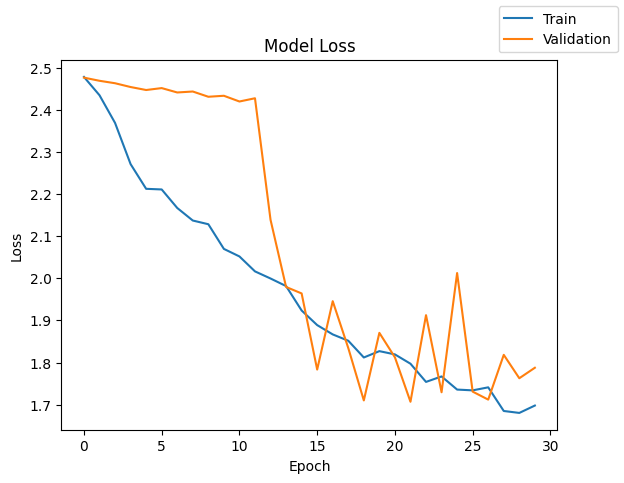

In [332]:
#Plot of Model Loss
plot(history_6,'loss')

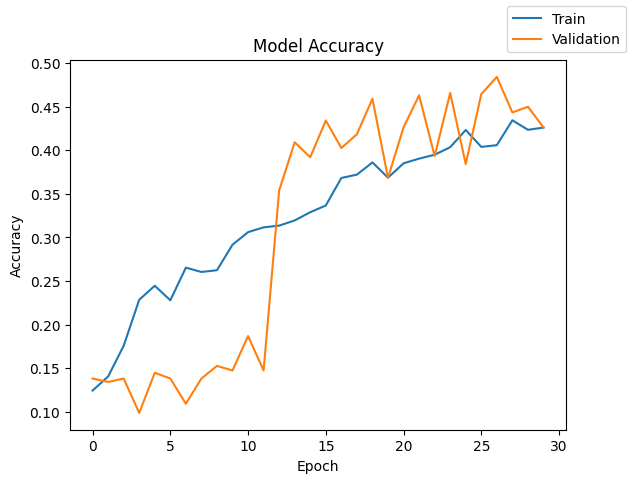

In [333]:
#plot of model accuracy
plot(history_6,'accuracy')

In [124]:
#Evaluate the model on test data
accuracy6 = model6.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 2.4321 - accuracy: 0.1379 - 406ms/epoch - 14ms/step


In [125]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model6.predict(X_test_normalized)

30/30 [==============================] - 0s 14ms/step


#### Model Performance and Confusion Matrix

In [334]:
# Model Performance on training data
model6_train_perf = model_performance_classification(model6,X_train_normalized,y_train_encoded)
print(model6_train_perf)

95/95 [==============================] - 1s 13ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.065789  0.065789    0.69452  0.078517


In [335]:
# Model Performance on validation data
model6_val_perf = model_performance_classification(model6,X_val_normalized,y_val_encoded)
print(model6_val_perf)

24/24 [==============================] - 0s 11ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.059211  0.059211    0.82648  0.066727


In [336]:
# Model Performance on testing data
model6_test_perf = model_performance_classification(model6,X_test_normalized,y_test_encoded)
print(model6_test_perf)

30/30 [==============================] - 0s 12ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.058947  0.058947   0.857293  0.067048


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [337]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report6 = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report6)

              precision    recall  f1-score   support

           0       0.48      0.21      0.29        53
           1       0.41      0.64      0.50        78
           2       0.82      0.24      0.37        58
           3       0.53      0.79      0.64       122
           4       1.00      0.00      0.00        44
           5       0.48      0.41      0.44        95
           6       0.54      0.93      0.69       131
           7       0.60      0.34      0.43        44
           8       0.56      0.29      0.38       103
           9       1.00      0.00      0.00        46
          10       0.51      0.75      0.60        99
          11       0.49      0.49      0.49        77

    accuracy                           0.51       950
   macro avg       0.62      0.42      0.40       950
weighted avg       0.58      0.51      0.46       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

- **We observe accuracy of 51%**
- **Macro Average F1 score of 40%**
- **Weighted average F1 score of 46%**

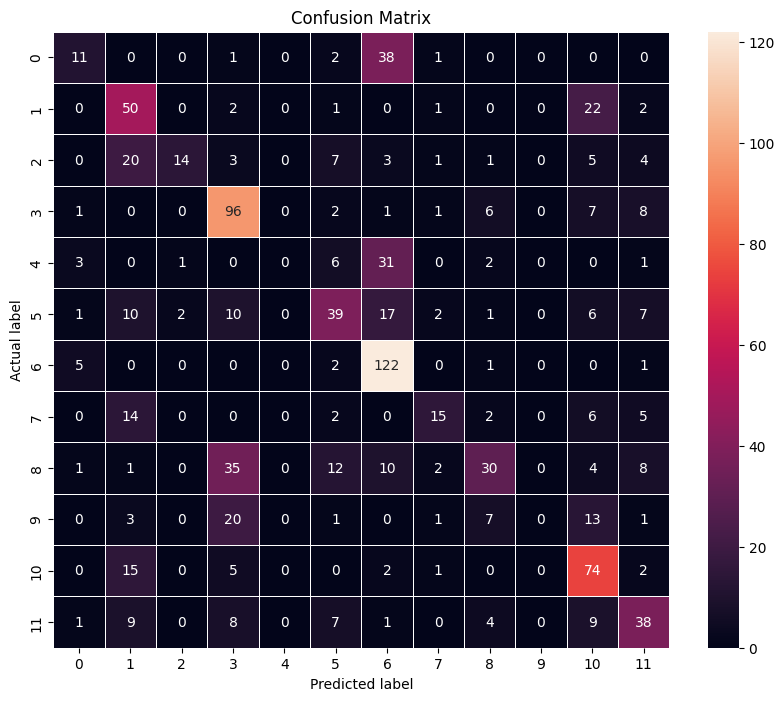

In [338]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- We observe that majority of the classes are not predicted correctly.Model is performing poorly
- In comparison to the rest, we can see that classes 1, 3 ,6 and 10 are well classified.
- We can also observe that classes 0,5,6,11 are mostly misclassified.
- 4,9 are mostly always wrongly predicted


## Final Model

### Helper Functions for Model Performance Comparison


In [383]:
def get_accuracy_from_report(report):
  """
  Extracts the accuracy value from a classification report string.

  Args:
    report: The classification report string.

  Returns:
    The accuracy value as a string, or None if not found.
  """
  accuracy_str = None

  # Find the line containing "accuracy"
  accuracy_str = re.search(r"accuracy\s+([\d.]+)", report)
  if accuracy_str: # Check if match found
    accuracy_str = accuracy_str.group(1)

  return accuracy_str


def get_precision_from_report(report,average):
  """
  Extracts the precision value from a classification report string.

  Args:
    report: The classification report string.

  Returns:
    The precision value as a string, or None if not found.
  """
  precision_str = None

  if average == "weighted avg" :
        # Find the line containing "weighted avg"
          weighted_avg_line = re.search(r"weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", report)
          if weighted_avg_line: # Check if match found
            precision_str = weighted_avg_line.group(1)
  elif average == "macro avg" :
          # Find the line containing "macro avg"
          macro_avg_line = re.search(r"macro avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", report)
          if macro_avg_line: # Check if match found
            precision_str = macro_avg_line.group(1)

  return precision_str


def get_recall_score_from_report(report,average):
  """
  Extracts the recall-score value from a classification report string.

  Args:
    report: The classification report string.

  Returns:
    The recall-score value as a string, or None if not found.
  """
  recall_str = None

  if average == "weighted avg" :
        # Find the line containing "weighted avg"
          weighted_avg_line = re.search(r"weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", report)
          if weighted_avg_line: # Check if match found
            recall_str = weighted_avg_line.group(2) # recall is the second group
  elif average == "macro avg" :
          # Find the line containing "macro avg"
          macro_avg_line = re.search(r"macro avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", report)
          if macro_avg_line: # Check if match found
            recall_str = macro_avg_line.group(2) # recall is the second group

  return recall_str


def get_f1_score_from_report(report,average):
  """
  Extracts the f1-score value from a classification report string.

  Args:
    report: The classification report string.

  Returns:
    The f1-score value as a string, or None if not found.
  """
  f1_score_str = None

  if average == "weighted avg" :
        # Find the line containing "weighted avg"
          weighted_avg_line = re.search(r"weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", report)
          if weighted_avg_line: # Check if match found
            f1_score_str = weighted_avg_line.group(3) # F1-score is the third group
  elif average == "macro avg" :
          # Find the line containing "macro avg"
          macro_avg_line = re.search(r"macro avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)", report)
          if macro_avg_line: # Check if match found
            f1_score_str = macro_avg_line.group(3) # F1-score is the third group

  return f1_score_str


### Model Performance Comparison

In [402]:
#models performance summary using history
model_accuracy = {
    "Models" : ["Model 1","Model 2","Model 3","Model 4","Model 5","Model 6"],
    "Model Description" : ["CNN Model",
    "CNN Data Augmentation with Rotation",
    "CNN Data Augmentation with more augmentation techniques",
    "CNN Data Augmentation with ReduceLROnPlateau()",
    "CNN Data Augmentation with ReduceLR and Batch Normalization",
    "CNN Data Augmentation with ReduceLR - Augmentation on Imbalanced data"  ],
    "Train Accuracy" :[ #Final Training Accuracy
        history_1.history['accuracy'][-1],
        history_2.history['accuracy'][-1],
        history_3.history['accuracy'][-1],
        history_4.history['accuracy'][-1],
        history_5.history['accuracy'][-1],
        history_6.history['accuracy'][-1],
    ],
    "Validation Accuracy" :[
        history_1.history['val_accuracy'][-1],
        history_2.history['val_accuracy'][-1],
        history_3.history['val_accuracy'][-1],
        history_4.history['val_accuracy'][-1],
        history_5.history['val_accuracy'][-1],
        history_6.history['val_accuracy'][-1],
    ],
    "Test Accuracy" :[
        accuracy1[1],
        accuracy2[1],
        accuracy3[1],
        accuracy4[1],
        accuracy5[1],
        accuracy6[1],
    ],
}

In [403]:
print("Model Summary on Test Data using History/Accuracy:")
model_df = pd.DataFrame(model_accuracy)
model_df.T

Model Summary on Test Data using History/Accuracy:


0                                    1  \
Models                 Model 1                              Model 2   
Model Description    CNN Model  CNN Data Augmentation with Rotation   
Train Accuracy        0.469737                             0.455645   
Validation Accuracy   0.576316                             0.584211   
Test Accuracy         0.608421                             0.586316   

                                                                     2  \
Models                                                         Model 3   
Model Description    CNN Data Augmentation with more augmentation t...   
Train Accuracy                                                0.410282   
Validation Accuracy                                           0.563158   
Test Accuracy                                                 0.572632   

                                                                  3  \
Models                                                      Model 4   
Model Description    CNN Data Augmentation with ReduceLROnPlateau()   
Train Accuracy                                             0.333669   
Validation Accuracy                                             0.4   
Test Accuracy                                              0.410526   

                                                                     4  \
Models                                                         Model 5   
Model Description    CNN Data Augmentation with ReduceLR and Batch ...   
Train Accuracy                                                0.467406   
Validation Accuracy                                           0.619737   
Test Accuracy                                                 0.613684   

                                                                     5  
Models                                                         Model 6  
Model Description    CNN Data Augmentation with ReduceLR - Augmenta...  
Train Accuracy                                                0.426075  
Validation Accuracy                                           0.426316  
Test Accuracy                                                 0.137895

- Model 5 CNN Data Augmentation with reduceLROnPlateau() and BatchNormalization() performs better than other models
with accuracy of 61.97 % on validation data and 61.4% on Testing data and 46.7% on Training

In [384]:
#models performance summary on test data using classification report
model_data = {
    "Models" : ["Model 1","Model 2","Model 3","Model 4","Model 5","Model 6"],
    "Model Description" : ["CNN Model",
    "CNN Data Augmentation with Rotation",
    "CNN Data Augmentation with more augmentation techniques",
    "CNN Data Augmentation with ReduceLROnPlateau()",
    "CNN Data Augmentation with ReduceLR and Batch Normalization",
    "CNN Data Augmentation with ReduceLR - Augmentation on Imbalanced data"  ],
    "Accuracy" :[
        accuracy1[1],
        accuracy2[1],
        accuracy3[1],
        accuracy4[1],
        accuracy5[1],
        accuracy6[1],
    ],
    "Loss" :[
        accuracy1[0],
        accuracy2[0],
        accuracy3[0],
        accuracy4[0],
        accuracy5[0],
        accuracy6[0],
    ],
    "Classification Report Accuracy" :[
        get_accuracy_from_report(report1),
        get_accuracy_from_report(report2),
        get_accuracy_from_report(report3),
        get_accuracy_from_report(report4),
        get_accuracy_from_report(report5),
        get_accuracy_from_report(report6),
    ],
    "Macro Avg Precision" :[
        get_precision_from_report(report1,'macro avg'),
        get_precision_from_report(report2,'macro avg'),
        get_precision_from_report(report3,'macro avg'),
        get_precision_from_report(report4,'macro avg'),
        get_precision_from_report(report5,'macro avg'),
        get_precision_from_report(report6,'macro avg'),
    ],
    "Weighted Avg Precision" :[
        get_precision_from_report(report1,'weighted avg'),
        get_precision_from_report(report2,'weighted avg'),
        get_precision_from_report(report3,'weighted avg'),
        get_precision_from_report(report4,'weighted avg'),
        get_precision_from_report(report5,'weighted avg'),
        get_precision_from_report(report6,'weighted avg'),
    ],
    "Macro Avg Recall" :[
        get_recall_score_from_report(report1,'macro avg'),
        get_recall_score_from_report(report2,'macro avg'),
        get_recall_score_from_report(report3,'macro avg'),
        get_recall_score_from_report(report4,'macro avg'),
        get_recall_score_from_report(report5,'macro avg'),
        get_recall_score_from_report(report6,'macro avg'),
    ],
    "Weighted Avg Recall" :[
        get_recall_score_from_report(report1,'weighted avg'),
        get_recall_score_from_report(report2,'weighted avg'),
        get_recall_score_from_report(report3,'weighted avg'),
        get_recall_score_from_report(report4,'weighted avg'),
        get_recall_score_from_report(report5,'weighted avg'),
        get_recall_score_from_report(report6,'weighted avg'),
    ],
    "Macro Avg F1-Score" :[
       get_f1_score_from_report(report1,'macro avg'),
       get_f1_score_from_report(report2,'macro avg'),
       get_f1_score_from_report(report3,'macro avg'),
       get_f1_score_from_report(report4,'macro avg'),
       get_f1_score_from_report(report5,'macro avg'),
       get_f1_score_from_report(report6,'macro avg'),
    ],
    "Macro Avg F1-Score" :[
        get_f1_score_from_report(report1,'macro avg'),
        get_f1_score_from_report(report2,'macro avg'),
        get_f1_score_from_report(report3,'macro avg'),
        get_f1_score_from_report(report4,'macro avg'),
        get_f1_score_from_report(report5,'macro avg'),
        get_f1_score_from_report(report6,'macro avg'),
    ],
    "Weighted Avg F1-Score":[
        get_f1_score_from_report(report1,'weighted avg'),
        get_f1_score_from_report(report2,'weighted avg'),
        get_f1_score_from_report(report3,'weighted avg'),
        get_f1_score_from_report(report4,'weighted avg'),
        get_f1_score_from_report(report5,'weighted avg'),
        get_f1_score_from_report(report6,'weighted avg'),
    ],
    "Time (seconds)" :[
        model1_time,
        model2_time,
        model3_time,
        model4_time,
        model5_time,
        model6_time,
    ]
  }

print("Model Summary on Test Data using Classification Report:")
model_data_df = pd.DataFrame(model_data)
model_data_df.T

Model Summary on Test Data using Classification Report:


0  \
Models                             Model 1   
Model Description                CNN Model   
Accuracy                          0.608421   
Loss                               1.20045   
Classification Report Accuracy        0.61   
Macro Avg Precision                   0.63   
Weighted Avg Precision                0.63   
Macro Avg Recall                      0.49   
Weighted Avg Recall                   0.61   
Macro Avg F1-Score                    0.45   
Weighted Avg F1-Score                 0.55   
Time (seconds)                  151.713536   

                                                                  1  \
Models                                                      Model 2   
Model Description               CNN Data Augmentation with Rotation   
Accuracy                                                   0.586316   
Loss                                                       1.146854   
Classification Report Accuracy                                 0.59   
Macro Avg Precision                                            0.69   
Weighted Avg Precision                                         0.65   
Macro Avg Recall                                               0.47   
Weighted Avg Recall                                            0.59   
Macro Avg F1-Score                                             0.43   
Weighted Avg F1-Score                                          0.52   
Time (seconds)                                           183.132764   

                                                                                2  \
Models                                                                    Model 3   
Model Description               CNN Data Augmentation with more augmentation t...   
Accuracy                                                                 0.572632   
Loss                                                                     1.359193   
Classification Report Accuracy                                               0.57   
Macro Avg Precision                                                          0.66   
Weighted Avg Precision                                                       0.63   
Macro Avg Recall                                                             0.45   
Weighted Avg Recall                                                          0.57   
Macro Avg F1-Score                                                           0.40   
Weighted Avg F1-Score                                                        0.50   
Time (seconds)                                                         189.401192   

                                                                             3  \
Models                                                                 Model 4   
Model Description               CNN Data Augmentation with ReduceLROnPlateau()   
Accuracy                                                              0.410526   
Loss                                                                  1.659105   
Classification Report Accuracy                                            0.41   
Macro Avg Precision                                                       0.75   
Weighted Avg Precision                                                    0.65   
Macro Avg Recall                                                          0.29   
Weighted Avg Recall                                                       0.41   
Macro Avg F1-Score                                                        0.20   
Weighted Avg F1-Score                                                     0.29   
Time (seconds)                                                      208.650388   

                                                                                4  \
Models                                                                    Model 5   
Model Description               CNN Data Augmentation with ReduceLR and Batch ...   
Accuracy                                                                 0.613684   
Loss 

-Based on the above comparison on the performance of the model , Model 5 - CNN Model - Data Augmentation with ReductionLR and Batch Normalization has better performance than other models .
- Model 5 has test accuracy of 61.4% and Model 1 is next good performance of 60.8% accuracy
Other models have lesser accuracy
- Model 5 has macro avg F1 score of 43% ,
- Model 5 has weighted avg F1 score of 53%,

**We will choose Model 5 as the best model**

### Final Model Selection

**- Model 5 is chosen as best model**


Comment on the final model you have selected and use the same in the below code to visualize the image.

### Visualizing the prediction

Assign the best chosen model and use it to visualise the prediction

In [404]:
new_model = model5

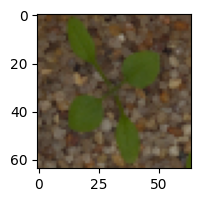

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Common Chickweed


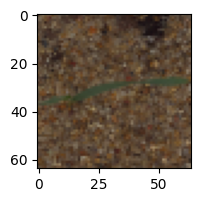

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Charlock']
True Label Charlock


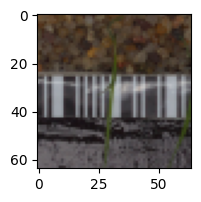

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


In [405]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[22])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[22].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[22])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[37])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[78])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[78].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[78])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

1. As we have seen, the CNN model with data-augmentation techiquest, reduceLROnPlateau() and Batch Normalization was able to predict the test image correctly with a test accuracy of 61.4%.

2. **There are still scope for improvement in the test accuracy of the CNN model** chosen here. **Different architectures** and **optimizers** can be used to built to obtain a better plant seed classifier.

3. Transfer learning can be applied to the dataset to improve the accuracy.

4. Once the desired performance is achieved from the model, the company can use it to classify different images being uploaded to the website.
5. For this project , we will choose model 5 that has the applied Batch Normalization techniques ,dataaugmentation rotation of images, and reduce learning rate callback parameter will be used and shared with the business.

## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- **Transfer Learning architecture**s can be used to train the CNN model to improve the performance and reap the benefits of Transfer Learning - less compute ,trained well even when input dataset is less. Pre-built architecture models like **VGG16**, can be used as that was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014. For training VGG16, directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, replace the existing fully-connected layers with FC layers created specifically for our problem.


_____

## Appendix: Transfer Learning using VGG16

In [289]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [290]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [291]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [292]:
#check all are non trainable params for VGG model
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [293]:
# Intializing a sequential model
model= Sequential()

# Adding the convolutional part of the VGG16 model from above
model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model.add(Flatten())

# Adding a fully connected dense layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(12, activation='softmax'))

In [294]:
# Adam as Optimizer
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                204       
                                                                 
Total params: 14747676 (56.26 MB)
Trainable params: 32988 (128.86 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


#### Fitting the model on training data

In [295]:
# Data generator with rotation set
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              fill_mode='nearest')

In [296]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

augmented_data = train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False)


In [297]:
start = time.time()
history = model.fit(augmented_data,
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=2)
end = time.time()

Epoch 1/30
47/47 - 26s - loss: 2.3741 - accuracy: 0.1851 - val_loss: 2.2333 - val_accuracy: 0.2684 - 26s/epoch - 553ms/step
Epoch 2/30
47/47 - 25s - loss: 2.2179 - accuracy: 0.2480 - val_loss: 2.1104 - val_accuracy: 0.3329 - 25s/epoch - 529ms/step
Epoch 3/30
47/47 - 26s - loss: 2.1321 - accuracy: 0.2698 - val_loss: 2.0070 - val_accuracy: 0.3605 - 26s/epoch - 551ms/step
Epoch 4/30
47/47 - 25s - loss: 2.0580 - accuracy: 0.2886 - val_loss: 1.9384 - val_accuracy: 0.3592 - 25s/epoch - 533ms/step
Epoch 5/30
47/47 - 25s - loss: 1.9577 - accuracy: 0.3205 - val_loss: 1.8319 - val_accuracy: 0.3908 - 25s/epoch - 530ms/step
Epoch 6/30
47/47 - 25s - loss: 1.9130 - accuracy: 0.3320 - val_loss: 1.7925 - val_accuracy: 0.4066 - 25s/epoch - 532ms/step
Epoch 7/30
47/47 - 25s - loss: 1.8406 - accuracy: 0.3545 - val_loss: 1.7275 - val_accuracy: 0.4197 - 25s/epoch - 528ms/step
Epoch 8/30
47/47 - 25s - loss: 1.8117 - accuracy: 0.3622 - val_loss: 1.6872 - val_accuracy: 0.4316 - 25s/epoch - 523ms/step
Epoch 9/

In [308]:
model_time = end-start
print("Time taken in minutes ",model_time/60)

Time taken in minutes  15.051047666867573


#### Model Evaluation

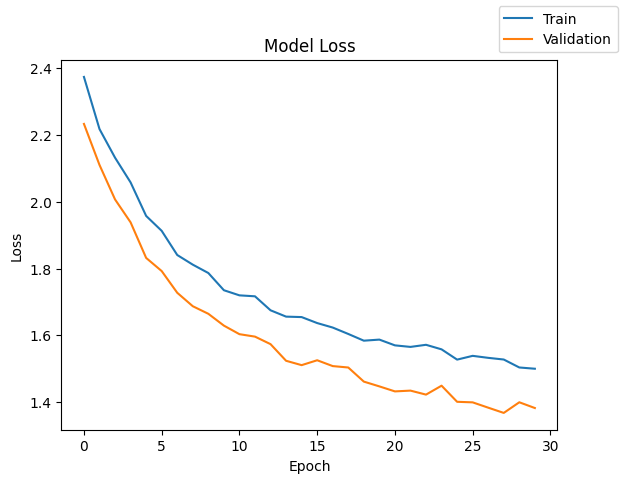

In [309]:
#Plot of Model Loss
plot(history,'loss')

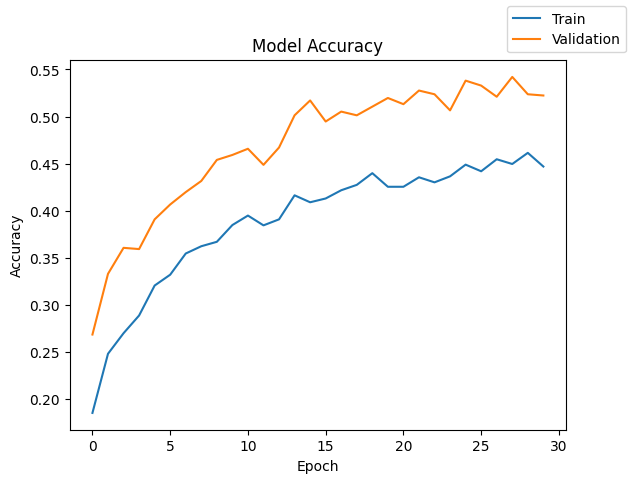

In [310]:
#plot of model accuracy
plot(history,'accuracy')

In [311]:
#Evaluate the model on test data
#model.evaluate() is used to evaluate the model's performance on the test dataset (X_test_normalized, y_test_encoded). This is the correct approach to get a final, unbiased assessment of the trained model
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 6s - loss: 1.3973 - accuracy: 0.5147 - 6s/epoch - 206ms/step


In [312]:
#Predictions on test data
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

30/30 [==============================] - 6s 197ms/step


#### Model Performance and Confusion Matrix

In [313]:
# Model Performance on training data
model_train_perf = model_performance_classification(model,X_train_normalized,y_train_encoded)
print(model_train_perf)

95/95 [==============================] - 19s 200ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.267434  0.267434   0.852746  0.328006


In [314]:
# Model Performance on validation data
model_val_perf = model_performance_classification(model,X_val_normalized,y_val_encoded)
print(model_val_perf)

24/24 [==============================] - 5s 206ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.218421  0.218421   0.819904  0.263313


In [315]:
# Model Performance on testing data
model_test_perf = model_performance_classification(model,X_test_normalized,y_test_encoded)
print(model_test_perf)

30/30 [==============================] - 6s 196ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.230526  0.230526    0.84502  0.282303


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes

In [316]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance summary using Classification report
report = classification_report(y_test_classes, y_pred_classes,zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.21      0.29        53
           1       0.41      0.64      0.50        78
           2       0.82      0.24      0.37        58
           3       0.53      0.79      0.64       122
           4       1.00      0.00      0.00        44
           5       0.48      0.41      0.44        95
           6       0.54      0.93      0.69       131
           7       0.60      0.34      0.43        44
           8       0.56      0.29      0.38       103
           9       1.00      0.00      0.00        46
          10       0.51      0.75      0.60        99
          11       0.49      0.49      0.49        77

    accuracy                           0.51       950
   macro avg       0.62      0.42      0.40       950
weighted avg       0.58      0.51      0.46       950



The classification report would help you determine how well the CNN model is identifying different plant species. By analyzing the metrics for each species, we can identify potential weaknesses (e.g., species that are frequently misclassified) and guide further model improvements.

**Test Data Performance**
- **We observe accuracy of 51% **
- **Macro Average F1 score of 40%**
- **Weighted average F1 score of 46%**

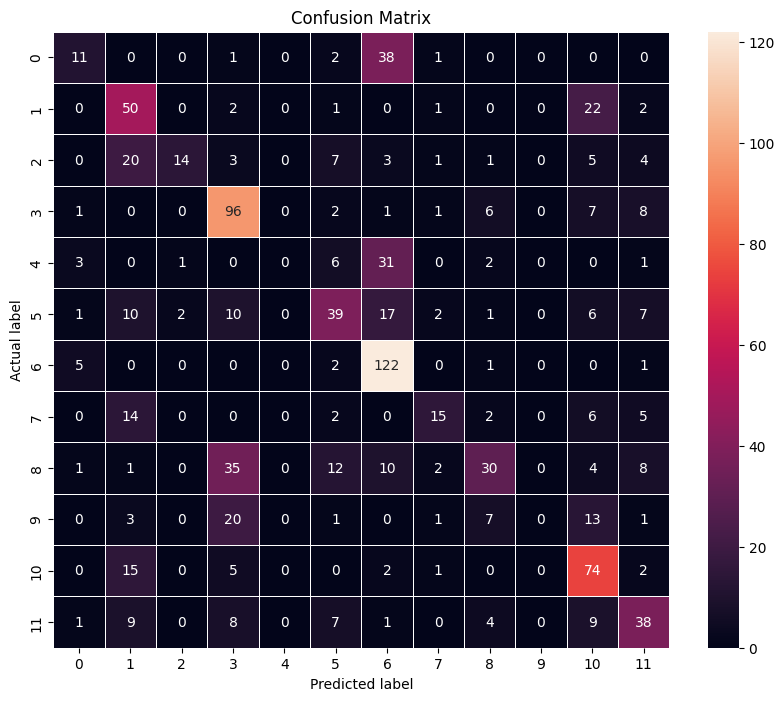

In [317]:
#call the defined helper function to display the heatmap of confusion_matrix
plot_confusion_matrix(y_test_classes,y_pred_classes)

<b> Observations:TensorFlow's confusion matrix function provides the raw counts</b><br>
- We observe that majority of the classes are not predicted correctly.
- VGG16 transfer learning has accuracy of 51% , Model can be fine tuned further by varying parameters,epochs,batch size ,different augmentation
- In comparison to the rest, we can see that classes  3 ,6 are classified better.
- 0 ,4 and 9 are mostly wrongly predicted
